# Deep Black-Box Optimization with Monte Carlo Dropout: RandomNN

Comparing GP-LCB, NN-INF, and NN-MCD.

In [1]:
from exp_sim_optim_simple import (
    setup_objective,
    run_sim_optim_gp,
    run_sim_optim_tf2,
    run_sim_optim_mcd_tf2,
    eval_hook,
    report_result,
    plot_regrets,
    plot_surface,
)
from exputils.models_tf import make_fcnet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

In [2]:
print("tensorflow:", tf.__version__)
print("torch:", torch.__version__)

tensorflow: 2.4.1
torch: 1.7.1


## Problem: Finding Minimum of a Random Neural Network

In [3]:
np.random.seed(1)
tf.random.set_seed(3)

In [4]:
# Common arguments
input_dim = 2
init_points = 10
max_iter = 100

# NN model arguments
layer_sizes = [16, 16, 8]
dropout = 0.25

In [5]:
# RandomNN arguments
n_layers = 10
n_units = 64
activation = "relu"
bound = 10.0
initializer = torch.nn.init.xavier_uniform_

problem, domain, X, Y = setup_objective(
    "RandomNN", 
    input_dim,
    init_points,
    n_layers=n_layers, 
    n_units=n_units,
    activation=activation,
    bound=bound,
    initializer=initializer,
)

## Baseline: GP-LCB

minimum: 0.24236339330673218
minimizer: [-2.2264272  -8.58666238]
elapsed time: 41.93 seconds


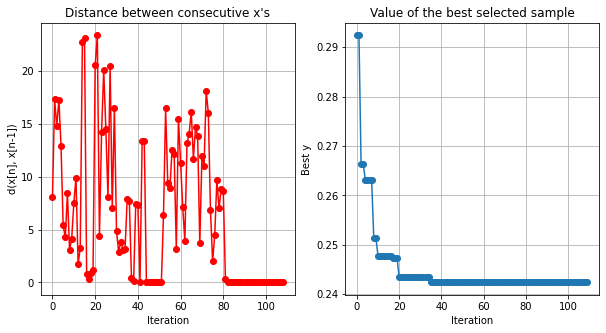

In [6]:
# ~45 seconds on laptop
gp_opt = run_sim_optim_gp(
    problem,
    domain,
    X,
    Y,
    max_iter=max_iter,
    acquisition_type="LCB",
)

## NN-MCD

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

Optimizing: 100%|██████████| 100/100 [00:21<00:00,  4.62it/s, R_i=0.0232, exp_w=4.81e+5, f*hat=0.266, fhat_i=0.296, r_i=0.0532, t_i=0.207, y_i=0.296, μ*=0.273, σ*=2] 


Elapsed Time: 21.63s
predicted minimum value: 0.27215638756752014 +/- 2.00000262260437
predicted minimizer: [10.         -1.67572749]
actual value at predicted minimizer: 0.2657589912414551


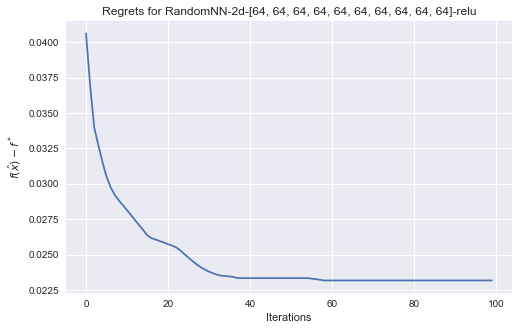

In [7]:
# ~120 seconds
nnmcd_tf2 = run_sim_optim_mcd_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    n_dropout_samples=100,
    lengthscale=1e-2,
    tau=0.25,
    max_iter=max_iter,
    exp_multiplier=1e3,
    exp_gamma=0.1,
    nn_optim_params={"learning_rate": 0.01},
    update_iters_per_point=10,
)

## NN-INF

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                48        
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                

Optimizing: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it, R_i=0.114, exp_w=4.81e+5, f*hat=0.357, fhat_i=0.357, r_i=0.114, t_i=1.23, y_i=0.357, μ*=0.356, σ*=1.55e-5]

Elapsed Time: 131.03s
predicted minimum value: 0.35337862372398376 +/- 7.189790267148055e-06
predicted minimizer: [-5.30472371  3.94708312]
actual value at predicted minimizer: 0.3122577369213104


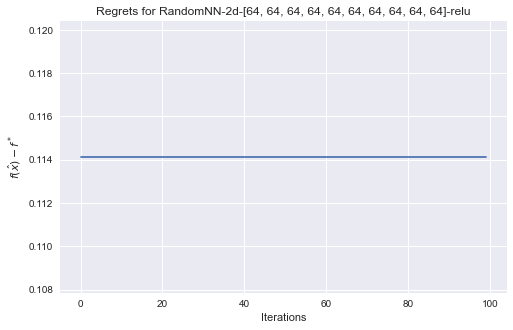

In [8]:
# ~250 seconds
nninf_tf2 = run_sim_optim_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    max_iter=max_iter,
    exp_multiplier=1e3,
    exp_gamma=0.1,
    nn_optim_params={"learning_rate": 0.01},
    update_iters_per_point=10,
)

## Combined Results

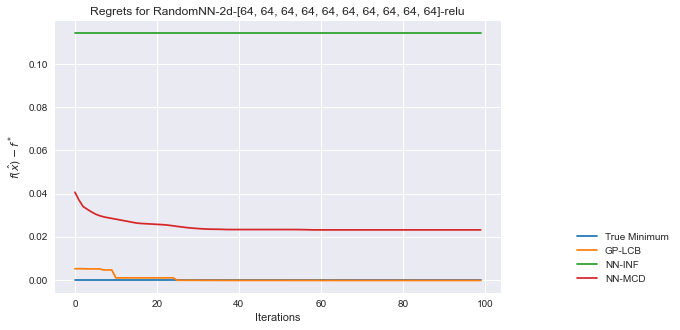

In [9]:
plot_regrets(
    [np.repeat(0, max_iter), 
     np.concatenate([gp_opt.Y_best[-max_iter:] - problem.fmin, 
                     np.repeat(np.nan, max(0, max_iter - len(gp_opt.Y_best)))]), 
     nninf_tf2["regrets"], 
     nnmcd_tf2["regrets"]],
    problem.name, 
    ["True Minimum", "GP-LCB", "NN-INF", "NN-MCD"],
)

True Minimum    : min 0.24259 at [-2.3232324 -8.787879 ]
GP-LCB          : min 0.24236 at [-2.2264272  -8.58666238]
NN-INF          : min 0.31226 at [-5.30472371  3.94708312]
NN-MCD          : min 0.26576 at [10.         -1.67572749]


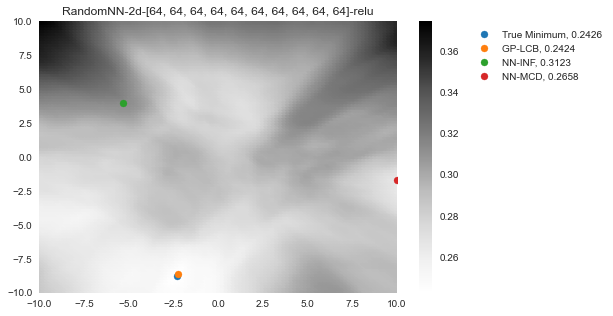

In [10]:
# NN Surface
minimizers = [
    (problem.min, problem.fmin, "True Minimum"),
    (gp_opt.x_opt, gp_opt.fx_opt, "GP-LCB"),
    (nninf_tf2["bo"].x_opt, nninf_tf2["bo"].fx_opt, "NN-INF"),
    (nnmcd_tf2["bo"].x_opt, nnmcd_tf2["bo"].fx_opt, "NN-MCD"),
]

plot_surface(problem, problem.bounds[0][1], minimizers, problem.name)